# HOG Facial detection Notebook 

- Óscar A. Alvarado
- Oscar A. Esquivel

In [ ]:
using Pkg
#Pkg.activate("/home/oscar/.julia/environments/HOG")
Pkg.activate("C:/Users/Óscar Alvarado/.julia/environments/HOG") # To use the correct environment

In [1]:
using ImageView, ImageDraw#, ImageMagick
using Images, ImageFeatures
using LIBSVM
using Random
using Statistics
using BenchmarkTools

┌ Info: Recompiling stale cache file /home/oscar/.julia/compiled/v1.1/ImageView/4mtgY.ji for ImageView [86fae568-95e7-573e-a6b2-d8a6b900c9ef]
└ @ Base loading.jl:1184
┌ Info: Recompiling stale cache file /home/oscar/.julia/compiled/v1.1/ImageDraw/Gb86X.ji for ImageDraw [4381153b-2b60-58ae-a1ba-fd683676385f]
└ @ Base loading.jl:1184
┌ Info: Recompiling stale cache file /home/oscar/.julia/compiled/v1.1/ImageFeatures/JMzL1.ji for ImageFeatures [92ff4b2b-8094-53d3-b29d-97f740f06cef]
└ @ Base loading.jl:1184


__________

In [2]:
pos_examples = "/home/oscar/Escritorio/HOG/faces/"
#pos_examples = "/home/oscar/Dropbox/JuliaCon/datasets/rawdata/"
neg_examples = "/home/oscar/Escritorio/HOG/not_faces/"

n_pos = length(readdir(pos_examples))   # number of positive training examples
n_neg = length(readdir(neg_examples))   # number of negative training examples
n = n_pos + n_neg                       # number of training examples 
labels = Vector{Int}(undef, n)          # Vector to store label (1=human, 0=not human) of each image.

tensor = zeros(n, 128, 128)
for (i, file) in enumerate([readdir(pos_examples); readdir(neg_examples)])
    filename = "$(i <= n_pos ? pos_examples : neg_examples)/$file"
    pure_img = load(filename)
    tensor[i,:,:] = Float64.(Gray.(pure_img))
    labels[i] = (i <= n_pos ? 1 : 0)
end

In [3]:
data = Array{Float64}(undef, 8100, n);   # This number only depends on the dimension of the images.
# ((cell_rows-block_size)/block_stride + 1) * ((cell_cols-block_size)/block_stride + 1) * (block_size*block_size) * orientations

for i = 1:div(n,2)
    data[:, i] = create_descriptor(tensor[i,:,:], HOG())
end

In [4]:
for i = div(n,2)+1:n
    data[:, i] = create_descriptor(tensor[i,:,:], HOG())
end

In [5]:
#Split the dataset into train and test set.
random_perm = randperm(n);
train_ind = random_perm[1:6000];
test_ind = random_perm[6001:end];

model = svmtrain(data[:, train_ind], labels[train_ind]);
#model = fit!(SVC(), data[:, train_ind]', labels[train_ind])

In [6]:
# Get test accuracy of our model
var = 30
predicted_labels, decision_values = svmpredict(model, data[:, test_ind[1:var]])
println(predicted_labels)
println(labels[test_ind[1:var]])
println(mean((predicted_labels .== labels[test_ind[1:var]]))*100) # test accuracy should be > 98%

[0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1]
[0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1]
100.0


In [7]:
function scan(step, path, s)
    pure_prueba = load(path)
    prueba = Float64.(Gray.(pure_prueba))
    rows, cols = size(prueba)

    descriptor = Array{Float64}(undef, 8100, 1)

    #Apply classifier using a sliding window approach and store classification score for not-human at every location 
    # in score array
    scores = Array{Float64}(undef, length(s:step:rows), length(s:step:cols))
    pred_lab = Array{Float64}(undef, length(s:step:rows), length(s:step:cols))
    list = []
    idx = 0
    for j in s:step:cols
        for i in s:step:rows
            #if i-(s-1) >= 300 || i-(s-1) <= 50 || j-(s-1) >= 1800 || j-(s-1) <= 158
            #    save("$neg_examples/of_$(idx).png", colorview(Gray, box))
            #    idx += 1
            #end
            descriptor[:, 1] = create_descriptor(prueba[i-(s-1):i, j-(s-1):j], HOG())
            predicted_label, dv = svmpredict(model, descriptor);
            #@show Int((i-s)/step)+1, Int((j-s)/step)+1
            pred_lab[Int((i-s)/step)+1, Int((j-s)/step)+1] = predicted_label[1] # The prediction label
            scores[Int((i-s)/step)+1, Int((j-s)/step)+1] = dv[1] # The score of the prediction 
        end
    end
    return scores, pred_lab
end

scan (generic function with 1 method)

In [40]:
step = 15
s = 128
#path = "/home/oscar/Dropbox/JuliaCon/queen.jpg"
path = "../Completa.jpg"
#path = "/home/oscar/Imágenes/dama.jpg"
scores, predicted_label = scan(step, path, s)
s_copy = scores[:,:]
s_copy2 = scores[:,:];

  257.718 s (13009721 allocations: 417.27 GiB)


In [41]:
sum(predicted_label)

6.0

In [42]:
s_copy[s_copy .> 0] .= 0
object_locations = findlocalminima(s_copy);

In [43]:
s_copy2[s_copy2 .< 0] .= 0
object_locations2 = findlocalmaxima(s_copy2);

In [44]:
object_locations2

2-element Array{CartesianIndex{2},1}:
 CartesianIndex(64, 21)
 CartesianIndex(20, 54)

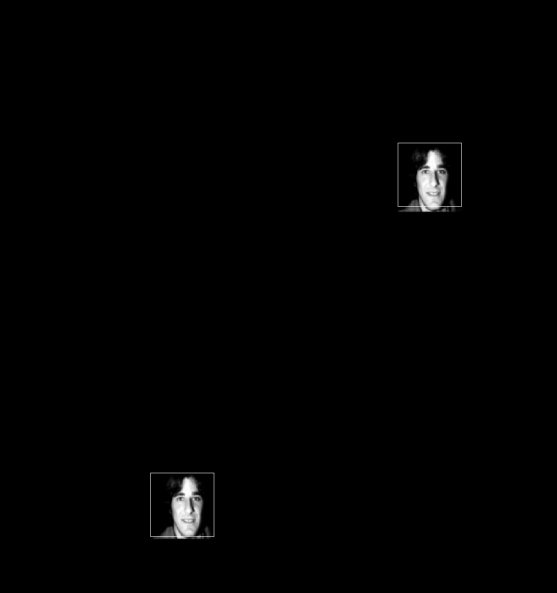

In [45]:
# We have to get rectangle vertex
pure_prueba = load(path)
prueba = Float64.(Gray.(pure_prueba))
rectangles = [[((i[2]-1)*step+1, (i[1]-1)*step+1), ((i[2]-1)*step+s, (i[1]-1)*step+1)
        , ((i[2]-1)*step+s, (i[1]-1)*step+s), ((i[2]-1)*step+1, (i[1]-1)*step+s)] for i in object_locations2];
a = Gray.(prueba)

for rec in rectangles
    draw!(a, Polygon(rec))
end
a

## Descomponiendo el algoritmo HOG

- imfilter

Para _gx_ se resta el de la izquierda. Las orillas se restan por par y para los demás se restan cada 2 lugares. Para _gy_ se resta el de arriba y se hace lo mismo con las orillas y no orillas. 

┌ Info: Recompiling stale cache file /home/oscar/.julia/compiled/v1.1/ImageMagick/0LbNX.ji for ImageMagick [6218d12a-5da1-5696-b52f-db25d2ecc6d1]
└ @ Base loading.jl:1184


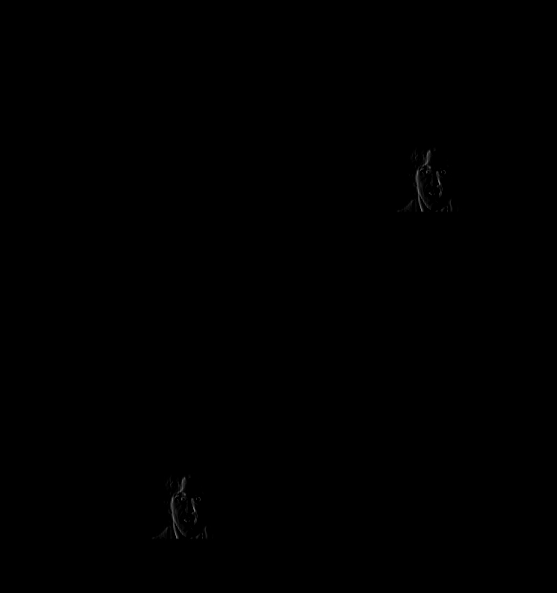

In [2]:
path = "../Completa.jpg"
pure_prueba = load(path)
prueba = Float64.(Gray.(pure_prueba))
Ax = hcat(prueba[:, 2:end], prueba[:, end])
Bx = hcat(prueba[:, 1], prueba[:, 1:(end-1)])
Ay = [prueba[2:end, :]; prueba[end, :]']
By = [prueba[1, :]'; prueba[1:(end-1), :]]
Gx = Ax - Bx # Esto podría ser paralelo
Gy = Ay - By # También
Gray.(Gx)

- Magnitud

Se suman los cuadrados de las matrices gx y gy píxel por píxel.

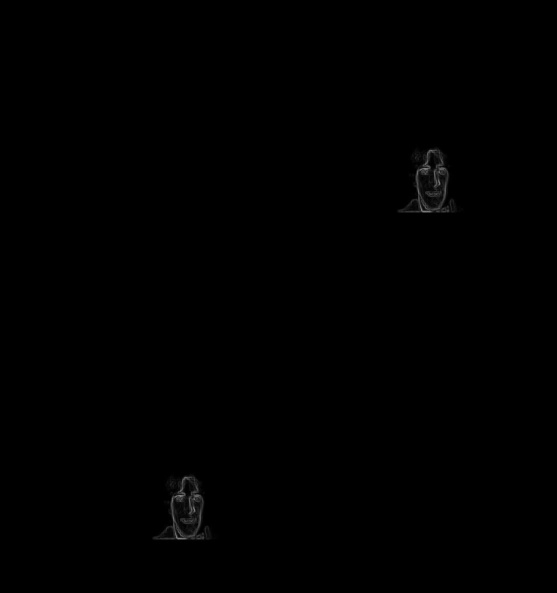

In [22]:
Gray.(sqrt.((Gx .* Gx) + (Gy .* Gy))) # La multiplicación entrada - entrada de matrices paralela

- Fase

In [24]:
Gx ./ Gy

1185×1113 Array{Float64,2}:
 NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  …  NaN  NaN  NaN  NaN  NaN  NaN  NaN
 NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN     NaN  NaN  NaN  NaN  NaN  NaN  NaN
 NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN     NaN  NaN  NaN  NaN  NaN  NaN  NaN
 NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN     NaN  NaN  NaN  NaN  NaN  NaN  NaN
 NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN     NaN  NaN  NaN  NaN  NaN  NaN  NaN
 NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  …  NaN  NaN  NaN  NaN  NaN  NaN  NaN
 NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN     NaN  NaN  NaN  NaN  NaN  NaN  NaN
 NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN     NaN  NaN  NaN  NaN  NaN  NaN  NaN
 NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN     NaN  NaN  NaN  NaN  NaN  NaN  NaN
 NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN     NaN  NaN  NaN  NaN  NaN  NaN  NaN
 NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  …  NaN  NaN  NaN  NaN  NaN  NaN  NaN
 NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN     NaN  NaN  NaN  NaN  NaN  NaN  NaN
 NaN  NaN  NaN  NaN  NaN  NaN  NaN  

In [23]:
atan.(Gx ./ Gy)

1185×1113 Array{Float64,2}:
 NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  …  NaN  NaN  NaN  NaN  NaN  NaN  NaN
 NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN     NaN  NaN  NaN  NaN  NaN  NaN  NaN
 NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN     NaN  NaN  NaN  NaN  NaN  NaN  NaN
 NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN     NaN  NaN  NaN  NaN  NaN  NaN  NaN
 NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN     NaN  NaN  NaN  NaN  NaN  NaN  NaN
 NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  …  NaN  NaN  NaN  NaN  NaN  NaN  NaN
 NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN     NaN  NaN  NaN  NaN  NaN  NaN  NaN
 NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN     NaN  NaN  NaN  NaN  NaN  NaN  NaN
 NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN     NaN  NaN  NaN  NaN  NaN  NaN  NaN
 NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN     NaN  NaN  NaN  NaN  NaN  NaN  NaN
 NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  …  NaN  NaN  NaN  NaN  NaN  NaN  NaN
 NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN     NaN  NaN  NaN  NaN  NaN  NaN  NaN
 NaN  NaN  NaN  NaN  NaN  NaN  NaN  

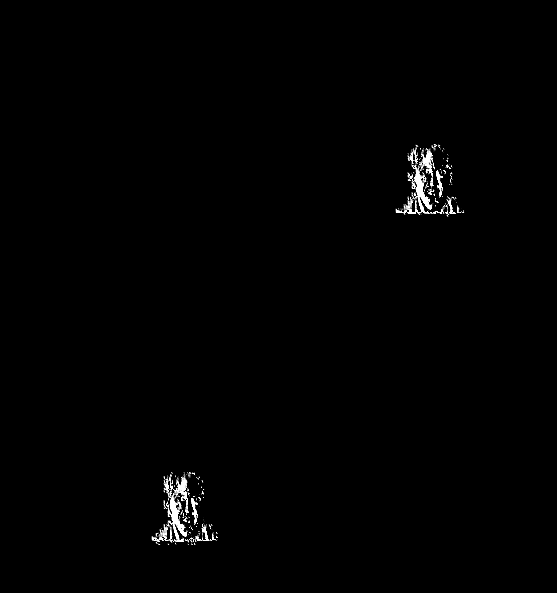

In [26]:
Gray.(orientation.(Gx, Gy)) # To get the arctan of Gx/Gy setting NaN values to zero

In [11]:
orientation.(1., 0.)

1.5707963267948966

In [6]:
arctan(1)

UndefVarError: UndefVarError: arctan not defined

- HOG Features

`hog_params = HOG([orientations = 9], [cell_size = 8], [block_size = 2], [block_stride = 1], [norm_method = "L2-norm"])`

In [50]:
ans*180/π

45.0

In [53]:
R = CartesianIndices(axes([3 3; 3 3]))

2×2 CartesianIndices{2,Tuple{Base.OneTo{Int64},Base.OneTo{Int64}}}:
 CartesianIndex(1, 1)  CartesianIndex(1, 2)
 CartesianIndex(2, 1)  CartesianIndex(2, 2)

In [54]:
for i = R
    println(i)
end

CartesianIndex(1, 1)
CartesianIndex(2, 1)
CartesianIndex(1, 2)
CartesianIndex(2, 2)


In [16]:
rows, cols

(1963, 1963)

In [17]:
1963/128

15.3359375

In [18]:
s:step:rows-s

128:10:1828